# Load packages

In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
import os
import math
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import calendar
sns.set(color_codes=True)

# Load data

In [2]:
folder_path = './data/'
dataset_path = 'daily_dataset.csv/'

In [3]:
# read data
energy = pd.read_csv(folder_path + dataset_path + 'daily_dataset.csv')
energy.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


In [4]:
household = pd.read_csv(folder_path+'informations_households.csv')
household.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [5]:
acorn_clean = pd.read_csv(folder_path + 'Acorn_cleaned_boolean.csv')
acorn_clean.head()

,Acorn,electricity,recycle,water,adult,child,elderly,attitude,car_0,car_1,...,60k-80k,80k-100k,<20k,>100k,average_level,internet_high,internet_low,internet_med,not_tv,tv
0,ACORN-A,0.058171,0.064323,0.063031,0.048746,0.058293,0.071493,0.0,0.011593,0.039859,...,0.117647,0.174914,0.011150,0.275769,0.113306,0.064831,0.040198,0.043906,0.060944,0.060048
1,ACORN-B,0.059651,0.063011,0.064790,0.051596,0.057692,0.067270,0.0,0.013105,0.028722,...,0.111176,0.142117,0.017606,0.179169,0.094712,0.064831,0.031960,0.035387,0.058083,0.065398
2,ACORN-C,0.061723,0.062427,0.063618,0.048461,0.047776,0.093213,0.0,0.012097,0.050996,...,0.078824,0.079402,0.038146,0.070696,0.067984,0.059667,0.049423,0.048493,0.050072,0.055886
3,ACORN-D,0.055062,0.062865,0.059513,0.071266,0.050781,0.031373,0.0,0.104839,0.055686,...,0.100000,0.120253,0.025235,0.144091,0.085997,0.067699,0.018451,0.022280,0.077825,0.063020
4,ACORN-E,0.058022,0.058926,0.061566,0.064282,0.064303,0.035596,0.0,0.059476,0.058617,...,0.089412,0.092060,0.032277,0.082029,0.073213,0.065404,0.025041,0.036697,0.076109,0.067182


In [6]:
acorn_clean_percentage = pd.read_csv(folder_path + 'Acorn_cleaned_percentage.csv')
acorn_clean_percentage = acorn_clean_percentage[['Acorn','attitude','environment_group']]
acorn_clean_percentage.rename(columns={'attitude':'attitude_per',
                                       'environment_group':'environment_group_per'},
                             inplace=True)

# Data cleaning
* Drop less than 2% of data in daily_dataset.csv
    * Keep records which be recorded 48 times a day (energy_count=48)
    * Keep records after 01/23/2012
    * Keep households which be recorded for more than 100 days
    * drop outliers
* Merge `daily_dataset.csv`, `informations_households.csv`, and `Acorn_cleaned_boolean.csv`
* Group by `LCLid` and calculate the average electricity usage

In [7]:
n = energy.shape[0]
energy = energy[energy.energy_count == 48].dropna()
start_date=datetime(year=2012,month=1,day=23)
energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d')
energy=energy.loc[energy["day"]>=start_date,['LCLid','day','energy_sum']].reset_index(drop=True)

percent = (n-energy.shape[0]) / n * 100
print('Dropped {n} records ({percent:.2f}%).'.format(n=n-energy.shape[0],percent=percent))
energy.head()

Dropped 58659 records (1.67%).


,LCLid,day,energy_sum
0,MAC000131,2012-01-23,11.641
1,MAC000131,2012-01-24,10.778
2,MAC000131,2012-01-25,11.499
3,MAC000131,2012-01-26,12.751
4,MAC000131,2012-01-27,10.672


In [8]:
cutoff = 100
daycount=energy.groupby(["LCLid"]).count()
# focus on selection criterai of 600 days at least
list_household=list(daycount[daycount.day<cutoff].index)
percent = len(list_household) / daycount.shape[0] * 100
energy = energy[~energy.LCLid.isin(list_household)]
print('Dropped {n} households ({percent:.2f}%).'.format(n=len(list_household),percent=percent))

Dropped 6 households (0.11%).


In [9]:
energy.to_csv(folder_path+'energy_cleaned.csv',index=False)

In [10]:
acorn_merge = energy[['LCLid','energy_sum']].groupby(['LCLid']).mean().reset_index()
acorn_merge = acorn_merge.merge(household[['LCLid','Acorn']],on='LCLid').\
                            merge(acorn_clean,on='Acorn').\
                            merge(acorn_clean_percentage,on='Acorn')

# correlation = acorn_merge.drop(['LCLid','Acorn'],1).corr()
# correlation.sort_values('energy_sum',ascending=False)

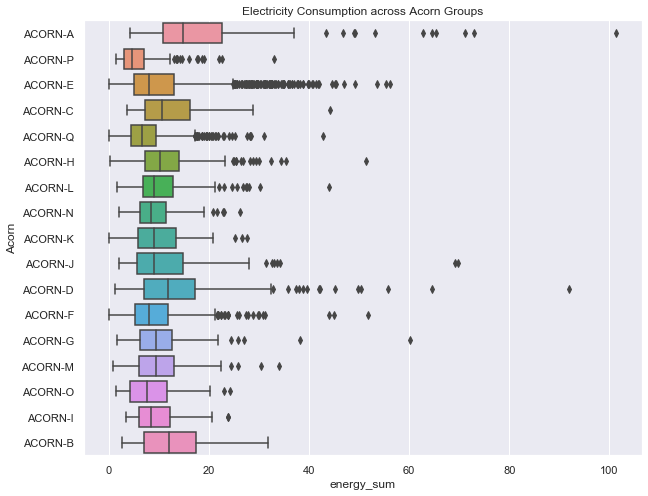

In [11]:
fig,ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x='energy_sum', y='Acorn', data=acorn_merge[['energy_sum','Acorn']])
ax.set_title('Electricity Consumption across Acorn Groups');

In [12]:
cutoff = 60
n = (acorn_merge.energy_sum>=cutoff).sum()
percent = n / acorn_merge.shape[0] * 100
acorn_merge = acorn_merge[acorn_merge.energy_sum<cutoff]
print('Dropped {n} records ({percent:.2f}%).'.format(n=n,percent=percent))

Dropped 11 records (0.20%).


In [13]:
acorn_merge.to_csv(folder_path+'acorn_merge_cleaned.csv',index=False)